In [5]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style
from TCGA_files import get_tcga_tissue

In [40]:
l = 0
#setup = '5000doc_0.25occ_fpkmweight_thr'
#setup='overlap_5000doc_0.25occ_fpkmweight_thr'
setup = 'oversigma_10tissue'
#label = 'disease_type'
labels = ['primary_site', 'secondary_site']
label=labels[0]
algorithm = "lda"
#directory = '/Users/filippo/Developer/tesi/results/hSBM/%s/topsbm'%(setup)
#directory = '/Users/filippo/Developer/tesi/gtex/hsbm/%s'%setup
#directory='/Users/filippo/Developer/tesi/merged/hsbm'
directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/gtex/hsbm/oversigma_10tissue"

In [25]:
df = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df.head()

,i_doc,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0,GTEX-1117F-0226-SM-5GZZ7,1.863510e-04,6.249209e-05,0.000649,1.267797e-04,0.000542,0.001169,0.902397,0.001469,0.062178,0.031221
1,1,GTEX-111CU-1826-SM-5GZYN,6.222789e-03,3.156604e-07,0.000589,3.156661e-07,0.001618,0.033626,0.630631,0.007978,0.002996,0.316338
2,2,GTEX-111FC-0226-SM-5N9B8,3.131243e-04,9.154440e-07,0.000845,5.754854e-03,0.003692,0.019786,0.659055,0.039376,0.023677,0.247500
3,3,GTEX-111VG-2326-SM-5N9BK,2.060209e-07,2.157223e-04,0.000190,6.228488e-04,0.003371,0.359085,0.252888,0.000820,0.007074,0.375734
4,4,GTEX-111YS-2426-SM-5GZZQ,5.342827e-04,2.213285e-03,0.000530,4.273231e-03,0.000571,0.028596,0.810000,0.010783,0.002258,0.140241


### Specific topic

In [ ]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, l, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,df,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc, df)

## Topic distr

### kl

In [ ]:
l=3

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files['primary_site'].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [26]:
l=0

In [27]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_files = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)['primary_site']))

<Figure size 432x288 with 0 Axes>

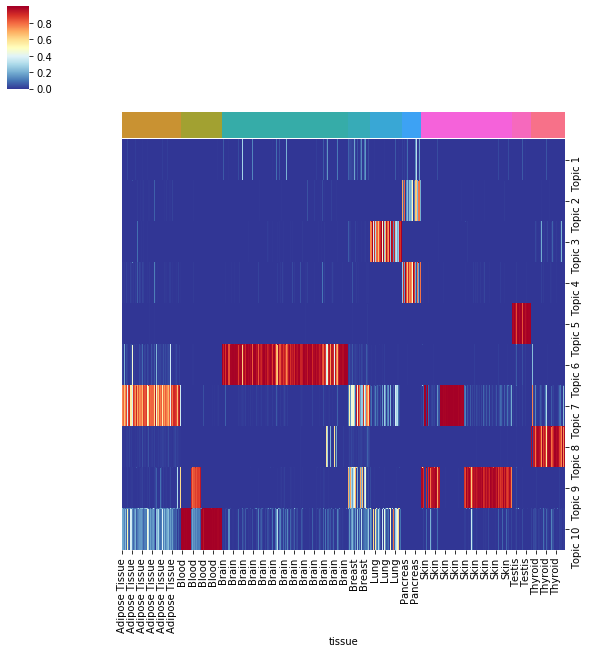

In [28]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', vmin=0, cmap='RdYlBu_r', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [29]:
df_topics = pd.read_csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)['primary_site'])

Adipose Tissue
Brain
Breast
Blood
Skin
Lung
Pancreas
Testis
Thyroid


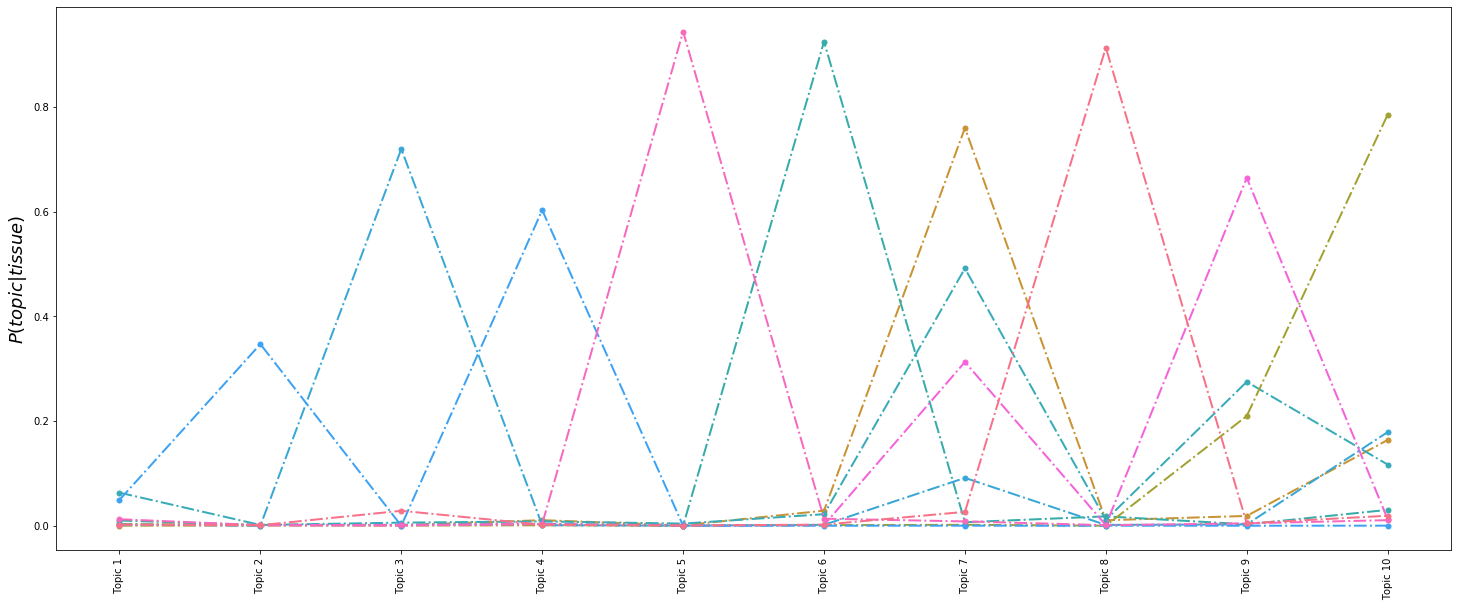

In [31]:
fig = plt.figure(figsize=(25,10))
for tissue in df_topics['tissue'].unique():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        plt.plot(df_topics[df_topics['tissue']==tissue].loc[:,df_topics.columns[0:16]].mean(axis=0), ls=ls,marker=marker, lw=2, ms=10, label=tissue, c=network_lut[df_files[df_files['primary_site']==tissue]['primary_site'][0]])
    except:
        pass
plt.xticks(rotation=90)
plt.ylabel("$P(topic | tissue)$", fontsize=18)
#plt.legend(fontsize=18)
plt.show()
fig.savefig("%s/%s/lifeplot.pdf"%(directory,algorithm))

In [32]:
expressedtopics = df_topics.drop('tissue', axis=1).mean(axis=0).sort_values(ascending=False).index

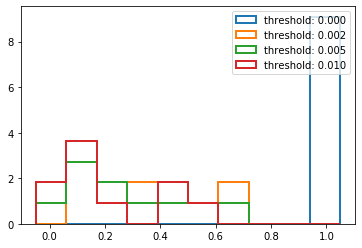

In [33]:
fig=plt.figure()
for thr in [0, 0.002, 0.005,0.01]:
    plt.hist(df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>thr])/float(len(x)), axis=1), histtype='step', density=True, range=(-0.05,1.05), bins=10, lw=2, label="threshold: %.3f"%thr)
plt.legend()
fig.savefig("%s/%s/distr_topicU.pdf"%(directory,algorithm))

In [34]:
topic_table = df_topics.drop('tissue', axis=1).transpose()
topic_table.insert(0,'occ', df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>0.002])/float(len(x)), axis=1).values)

In [35]:
low_occ_topics = topic_table[topic_table['occ']<0.5].index.values
l_topics_i = [int(t[6:])-1 for t in low_occ_topics]
#l_topics_i = np.random.randint(0,100,10)

In [36]:
import findspark
findspark.init()
import pyspark as spark
import tensorflow as tf
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [41]:
df_files_pd = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics = sql.read.option("header","true").csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,l))
df_files = sql.read.option("header","true").csv("%s/files.dat"%(directory))
df_files.registerTempTable("file")
df_topics = df_topics.withColumn('status', udf(lambda x: 'healthy' if 'GTEX' in x else 'tumour', StringType())(col('doc')))
df_topics = df_topics.withColumn('tissue', udf(lambda x: get_file(x, df_files_pd)[labels[0]], StringType())(col('doc')))
df_topics = df_topics.withColumn('second_tissue', udf(lambda x: get_file(x, df_files_pd)[labels[1]], StringType())(col('doc')))
df_topics.registerTempTable("topic")

### only health vs disease

In [42]:
dftf_h = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='healthy'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='tumour'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)

In [ ]:
with tf.Session() as sess:
    results = sess.run([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)])

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0][l_topics_i], marker='o', lw=0.1)
plt.plot(results[1][l_topics_i],marker='x', lw=0.1)
plt.show()

### all

In [43]:
df_all = tf.convert_to_tensor(sql.sql("SELECT * FROM topic").toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float))

In [44]:
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.math.reduce_mean(df_all, 0))
normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [45]:
with tf.Session() as sess:
    result = sess.run([normed_df])

In [ ]:
fig=plt.figure(figsize=(30,15))
label = 'tissue'
for tissue in ['breast-gtex', 'breast-tcga', 'colon-gtex', 'colon-tcga','thyroid-gtex','thyroid-tcga']:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.1, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=16, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | sample) - mean\\right|}{\sigma}$", fontsize=18)
plt.xticks(ticks=np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), labels=low_occ_topics, rotation=90)
#plt.yscale('log')
plt.show()
fig.savefig("%s/lifeplot_normalised_level%d_hd.pdf"%(directory,l))

Skin


<Figure size 2160x1080 with 0 Axes>

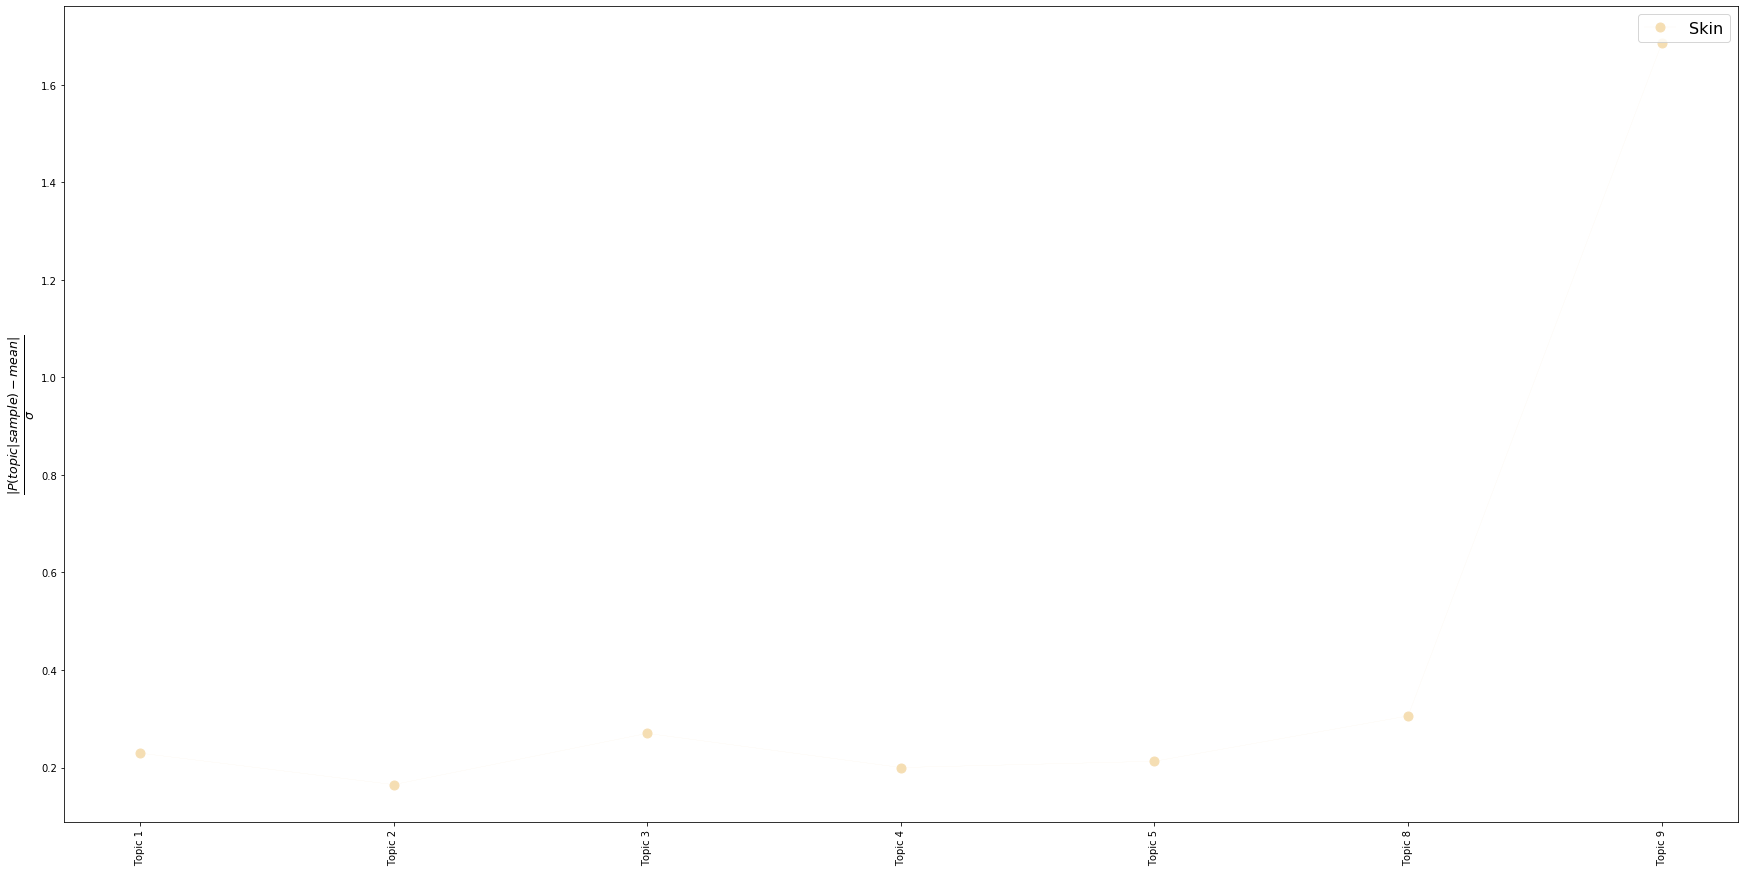

Adipose Tissue


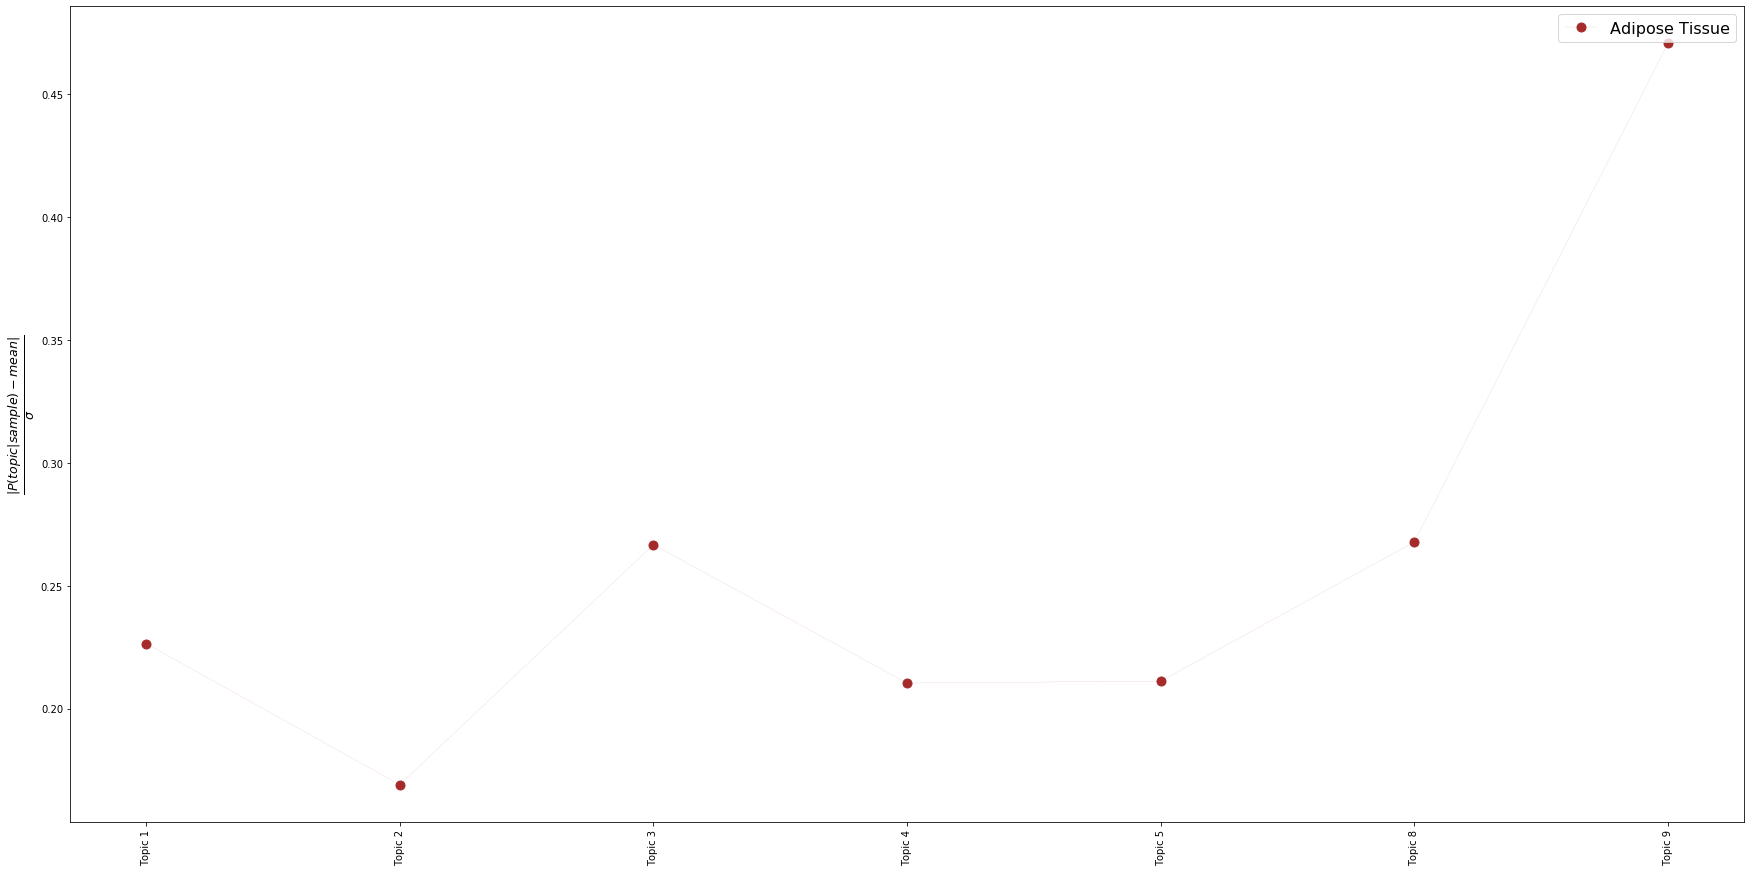

Blood


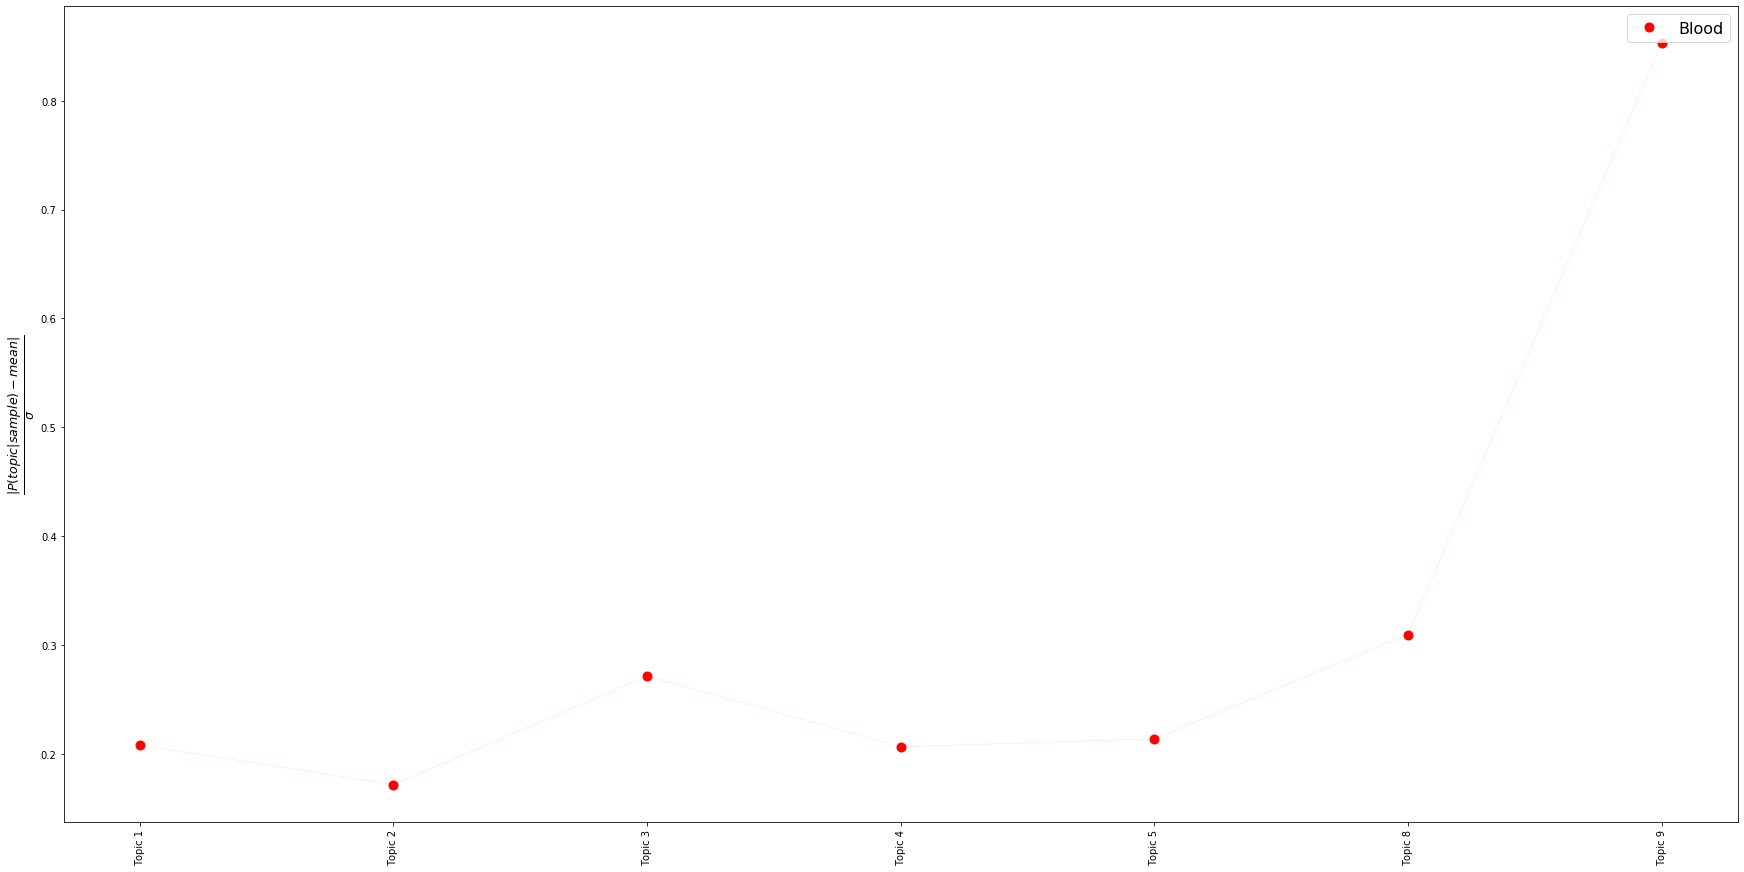

Thyroid


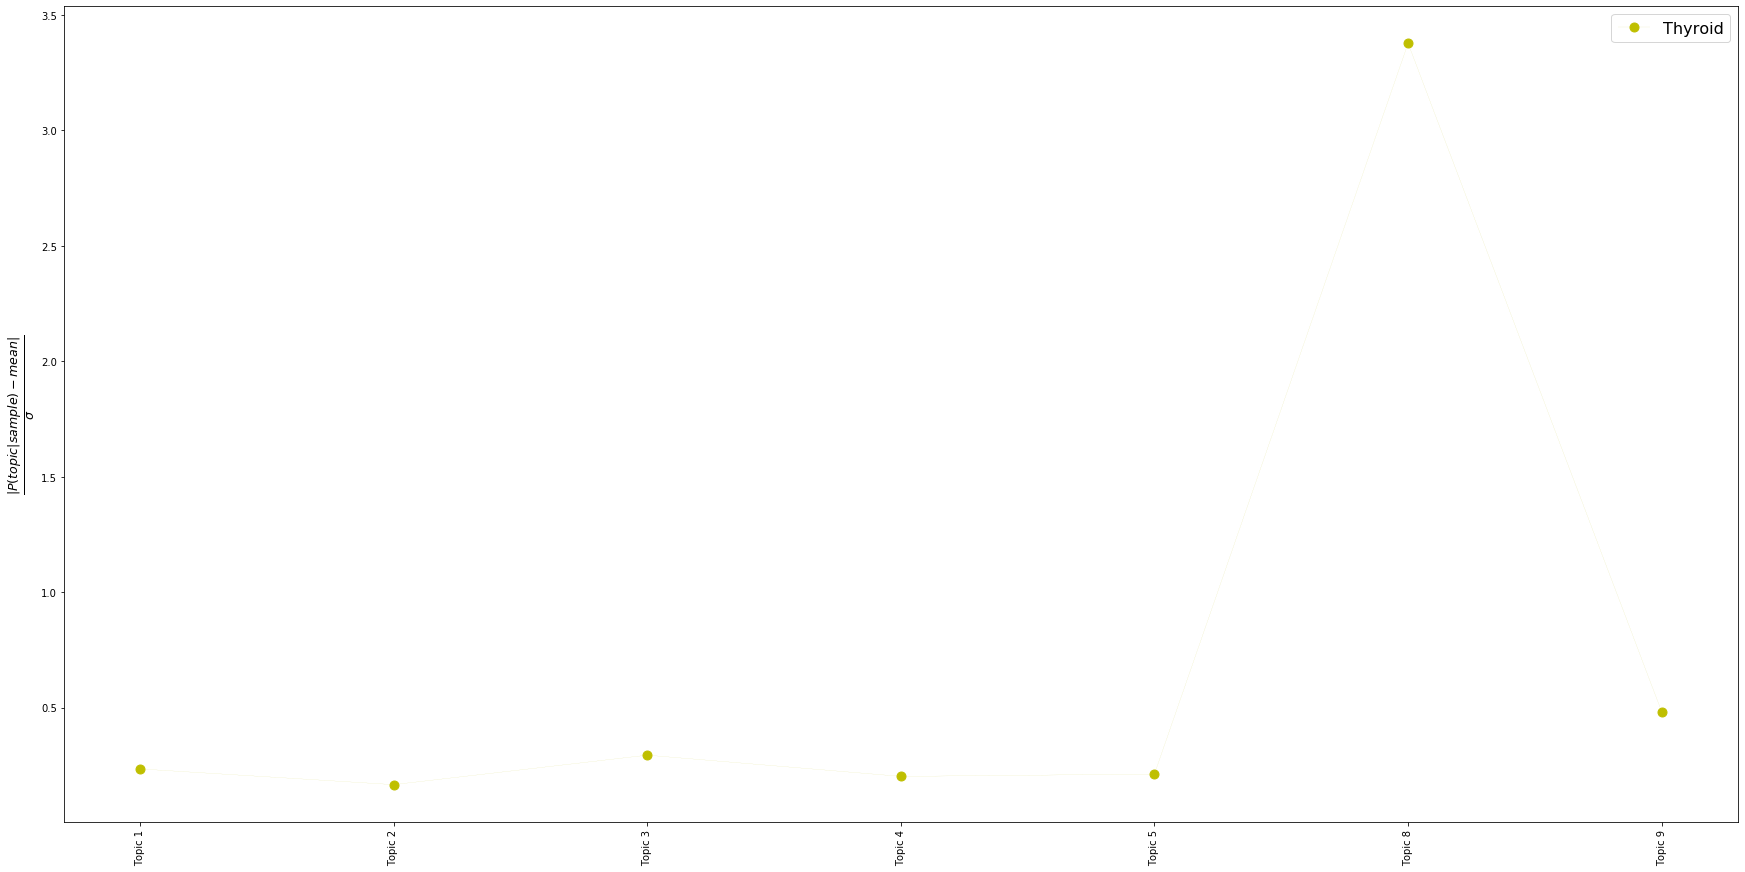

Pancreas


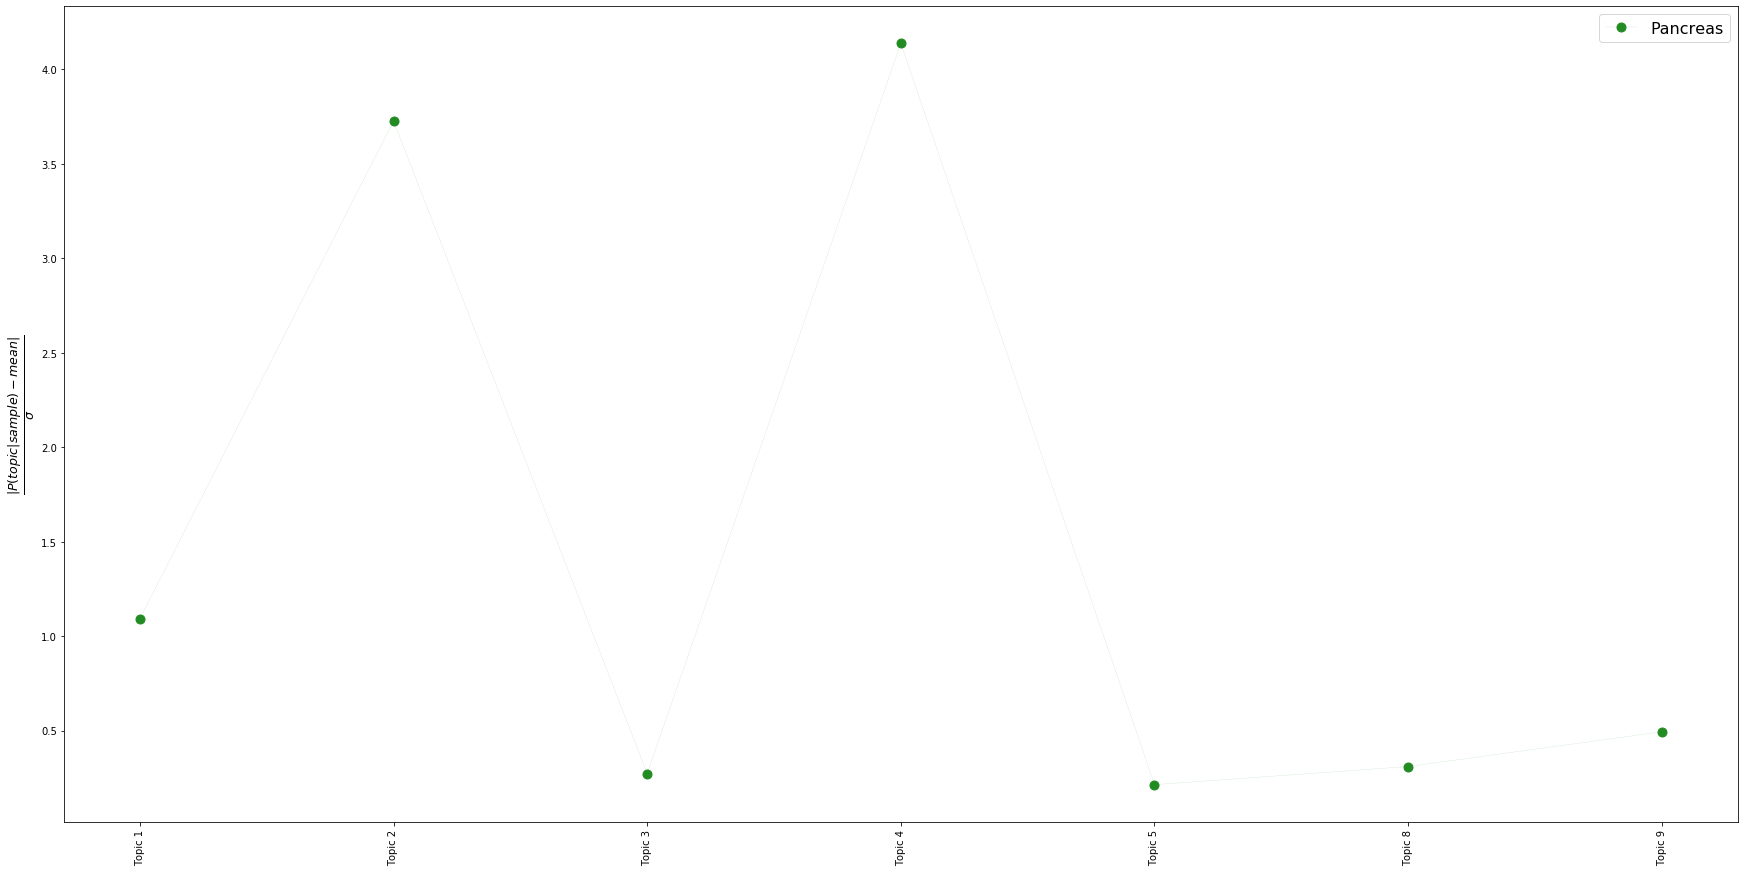

Brain


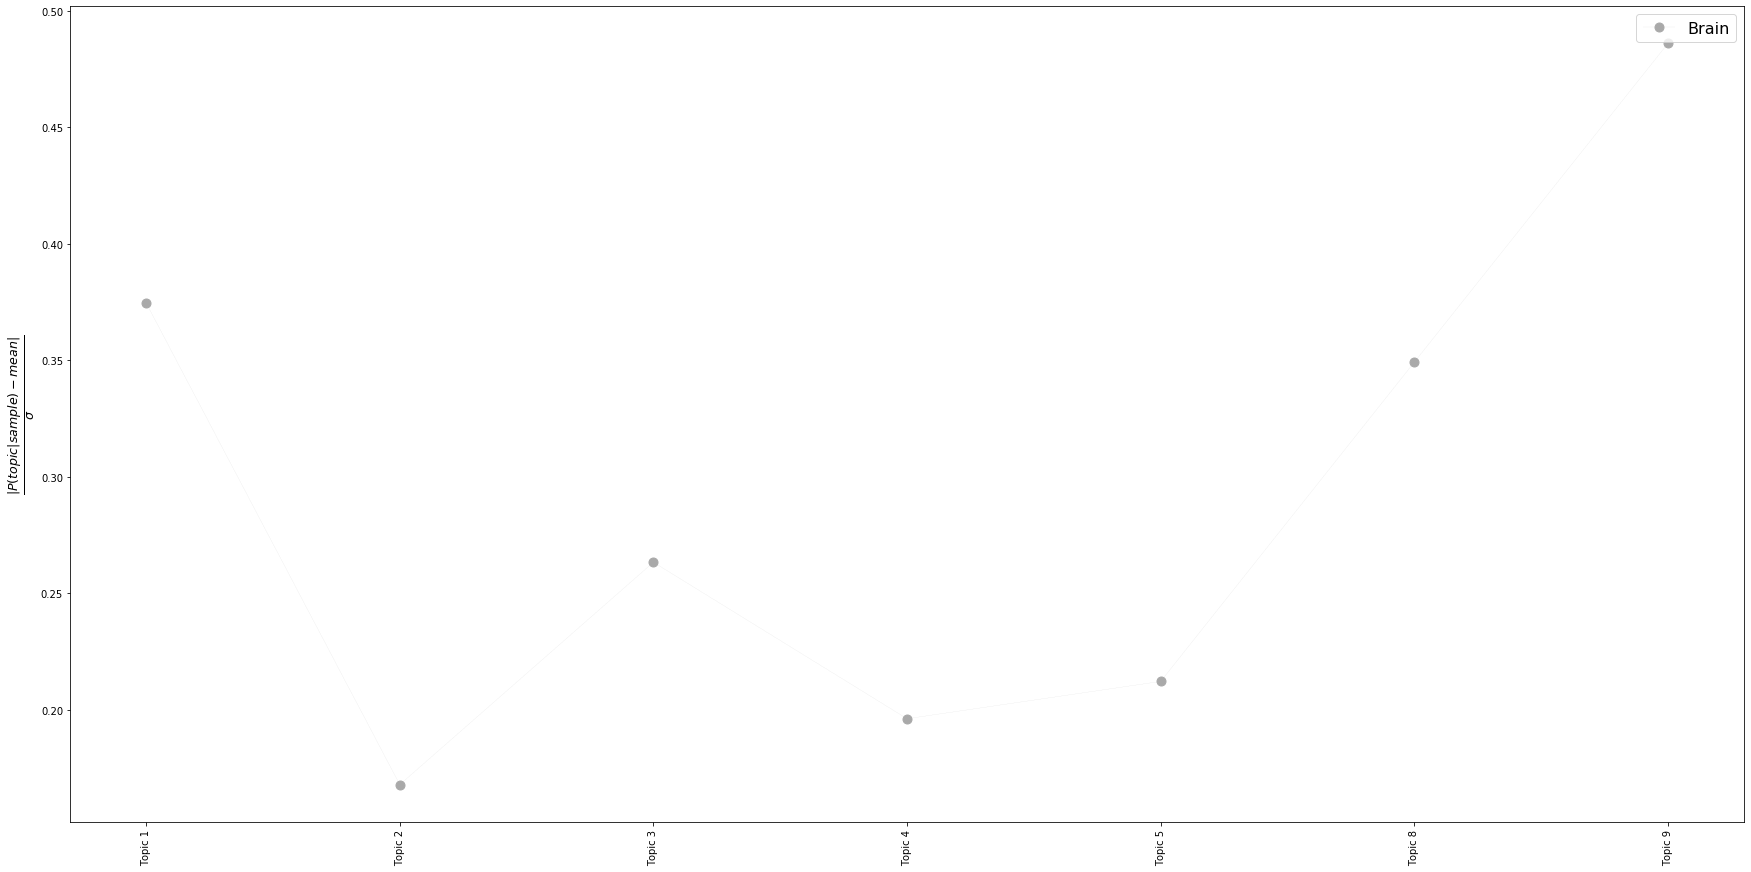

Lung


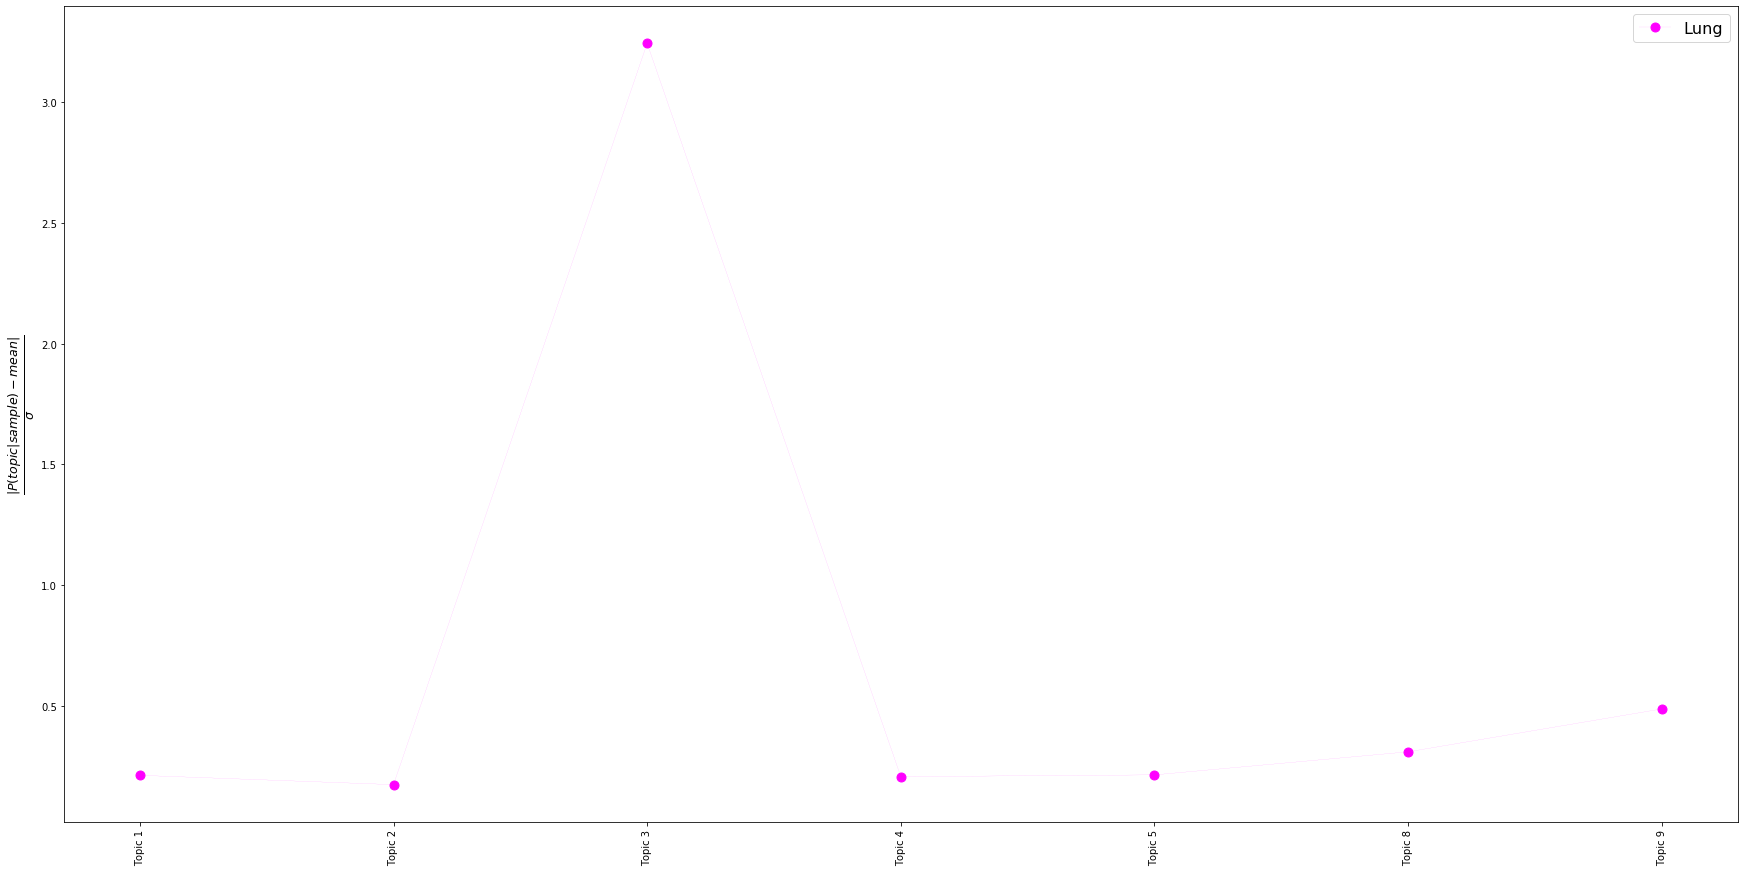

Testis


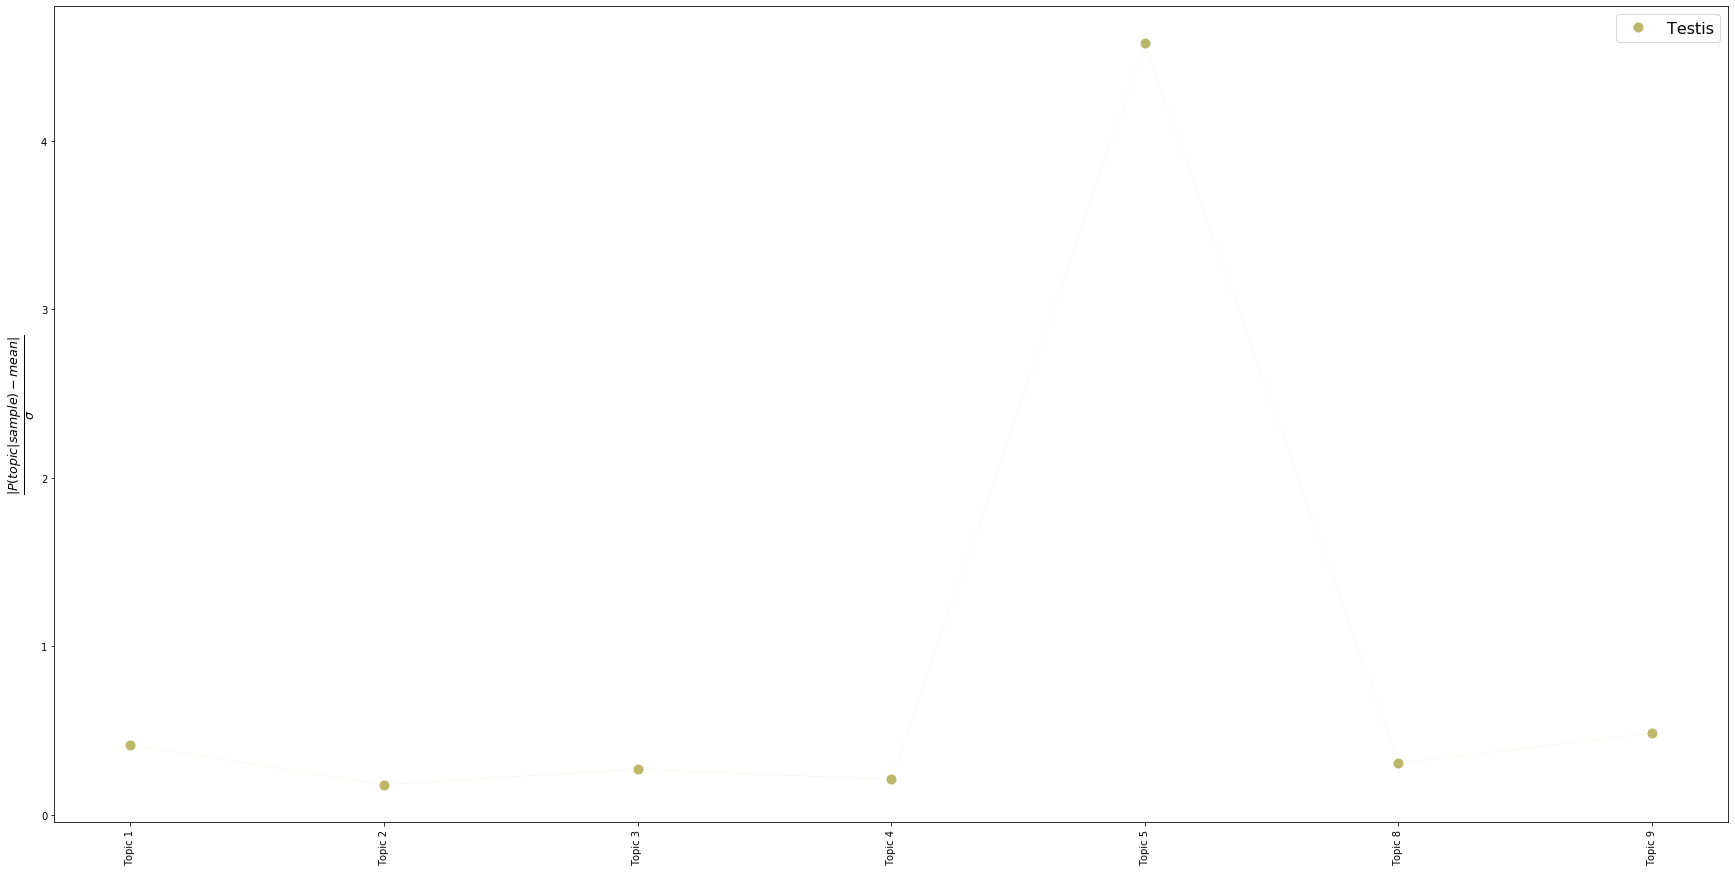

Breast


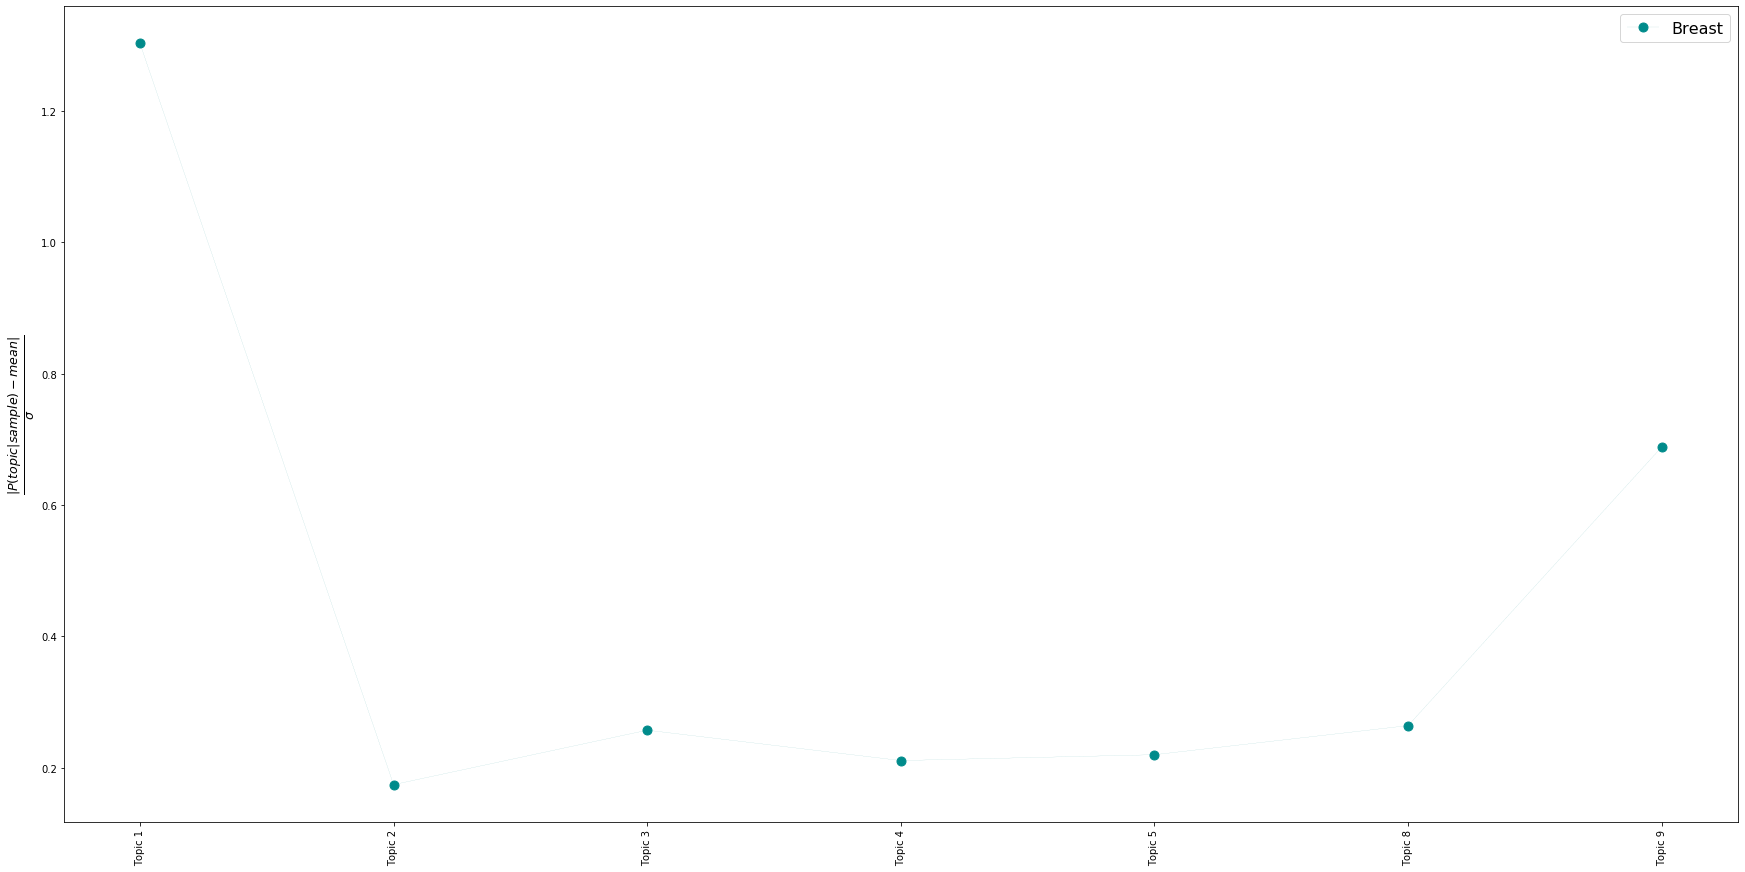

In [46]:
fig=plt.figure(figsize=(30,15))
label='tissue'
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    fig=plt.figure(figsize=(30,15))
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.1, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
    plt.legend(fontsize=16, ncol=4)
    plt.ylabel("$\\frac{\\left|P(topic | sample) - mean\\right|}{\sigma}$", fontsize=18)
    plt.xticks(ticks=np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), labels=low_occ_topics, rotation=90)
    plt.show()
    fig.savefig("%s/%s/lifeplot_normalised_%s_%s.pdf"%(directory,algorithm,label,tissue))

In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import get_tissue_style

Skin


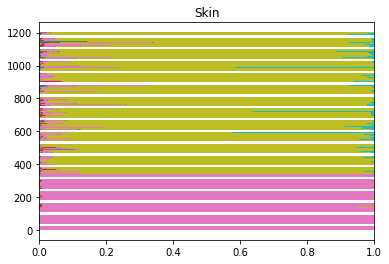

Adipose Tissue


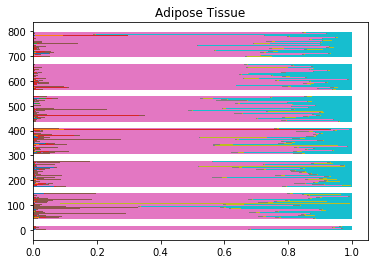

Blood


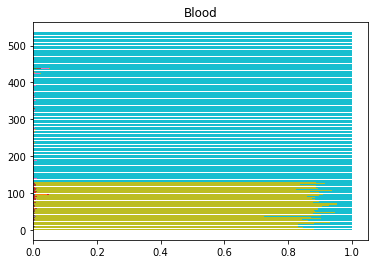

Thyroid


KeyboardInterrupt: 

In [53]:
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = sql.sql("SELECT * FROM topic WHERE tissue='%s'"%tissue).toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.columns:
        plt.barh(df_visual.index.values,df_visual[t].values,left=width)
        width+=df_visual[t].values
    plt.show()
    fig.savefig("%s/%s/topicvisual_%s.png"%(directory,algorithm,tissue))

In [54]:
tf.reset_default_graph()
sc.stop()